In [ ]:
train_batch_folder = "data"
train_batches_json = ["20210511_seg-batch-37-2021-05-11.json", "20210511_seg-batch-38-2021-05-11.json", "20210511_seg-batch-38-2021-05-11.json", 
                      "20210511_seg-batch-39-2021-05-11.json", "20210511_seg-batch-40-2021-05-11.json", "20210511_seg-batch-41-2021-05-11.json",
                      "20210511_seg-batch-42-2021-05-11.json", "20210511_seg-batch-43-2021-05-11.json", "20210511_seg-batch-44-2021-05-11.json",
                      "20210511_seg-batch-45-2021-05-11.json", "20210511_seg-batch-46-2021-05-11.json", "20210511_seg-batch-47-2021-05-11.json",
                      "20210511_seg-batch-48-2021-05-11.json", "20210511_seg-batch-49-2021-05-11.json", "20210511_seg-batch-50-2021-05-11.json",
                      "20210511_seg-batch-51-2021-05-11.json", "20210511_seg-batch-52-2021-05-11.json", "20210511_seg-batch-53-2021-05-11.json",
                      "20210511_seg-batch-54-2021-05-11.json", "20210511_seg-batch-55-2021-05-11.json", "20210511_seg-batch-56-2021-05-11.json",
                      "20210511_seg-batch-57-2021-05-11.json", "20210511_seg-batch-58-2021-05-11.json", "20210511_seg-batch-59-2021-05-11.json",
                      "20210511_seg-batch-60-2021-05-11.json", "20210511_seg-batch-61-2021-05-11.json", "20210511_seg-batch-62-2021-05-11.json",
                      "20210511_seg-batch-62-2021-05-11.json", "20210511_seg-batch-63-2021-05-11.json", "20210511_seg-batch-64-2021-05-11.json",
                      "20210511_seg-batch-65-2021-05-11.json", "20210511_seg-batch-66-2021-05-11.json", "20210511_seg-batch-67-2021-05-11.json",
                    ]
valid_batch_folder = "data"
valid_batches_json = ["20210511_seg-batch-68-2021-05-11.json", "20210511_seg-batch-69-2021-05-11.json", "20210511_seg-batch-70-2021-05-11.json", 
                      "20210511_seg-batch-71-2021-05-11.json", "20210511_seg-batch-72-2021-05-11.json", "20210511_seg-batch-73-2021-05-11.json",
                      "20210511_seg-batch-74-2021-05-11.json",
                    ]
label_dict = {"Road": 1, "BAU":2, "SW": 3}

download_images = False
resize_height_image = 128
resize_width_image = 128

In [ ]:
import torch as th
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms
from pytorch_lightning import Trainer
import numpy as np
import albumentations as A
import pprint as pp
import json
import cv2

from datasets.augmentations import ApplyAlbumination, compose, transposeImage, convertImage2float, convertMask2long
from datasets.io import labeler_image_mask_load, rescale_labeler_image_mask_load
from datasets import labeler_download_lot, ImageMaskDataset
from models.unet import UnetTrainer

th.manual_seed(42)

# sanity check for data label dictionary
n_classes = len(list(label_dict.keys())) + 1
assert n_classes == max(list(label_dict.values())) + 1

# data formatting
# data loading from labeler format
image_mask_load_fun=labeler_image_mask_load(maks_label_dict=label_dict)
# data loadinf and rescale
image_load_fun = rescale_labeler_image_mask_load((resize_height_image, resize_width_image), image_mask_load_fun=image_mask_load_fun)

# load train data batches
train_batches = []
for train_batch_json in train_batches_json:
    image_folder, mask_folder  = labeler_download_lot(os.path.join(train_batch_folder, train_batch_json), only_labels=not download_images)
    ds = ImageMaskDataset(image_folder, mask_folder, image_prefix="", mask_prefix="", image_suffix=".png", mask_suffix=".json",
                          image_mask_load_fun=image_load_fun)
    train_batches += [ds]
train_dataset = ConcatDataset(train_batches)
    
# load valid data batches
valid_batches = []
for valid_batch_json in valid_batches_json:
    image_folder, mask_folder  = labeler_download_lot(os.path.join(valid_batch_folder, valid_batch_json), only_labels=not download_images)
    ds = ImageMaskDataset(image_folder, mask_folder, image_prefix="", mask_prefix="", image_suffix=".png", mask_suffix=".json",
                          image_mask_load_fun=image_load_fun)
    valid_batches += [ds]
valid_dataset = ConcatDataset(valid_batches)

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show(images, masks, alpha=0.3, **kwargs):
    assert len(images) == len(masks), "images and masks must be the same!"
    N = len(images)
    n = int(np.floor(np.sqrt(len(images))))
    fig, axs = plt.subplots(ncols=n, nrows=n+int(N%n!=0), **kwargs)
    for idx, (image, mask) in enumerate(zip(images, masks)):
        axs[idx//n, idx%n].imshow(image)
        axs[idx//n, idx%n].imshow(mask, alpha=alpha)
    return fig, axs

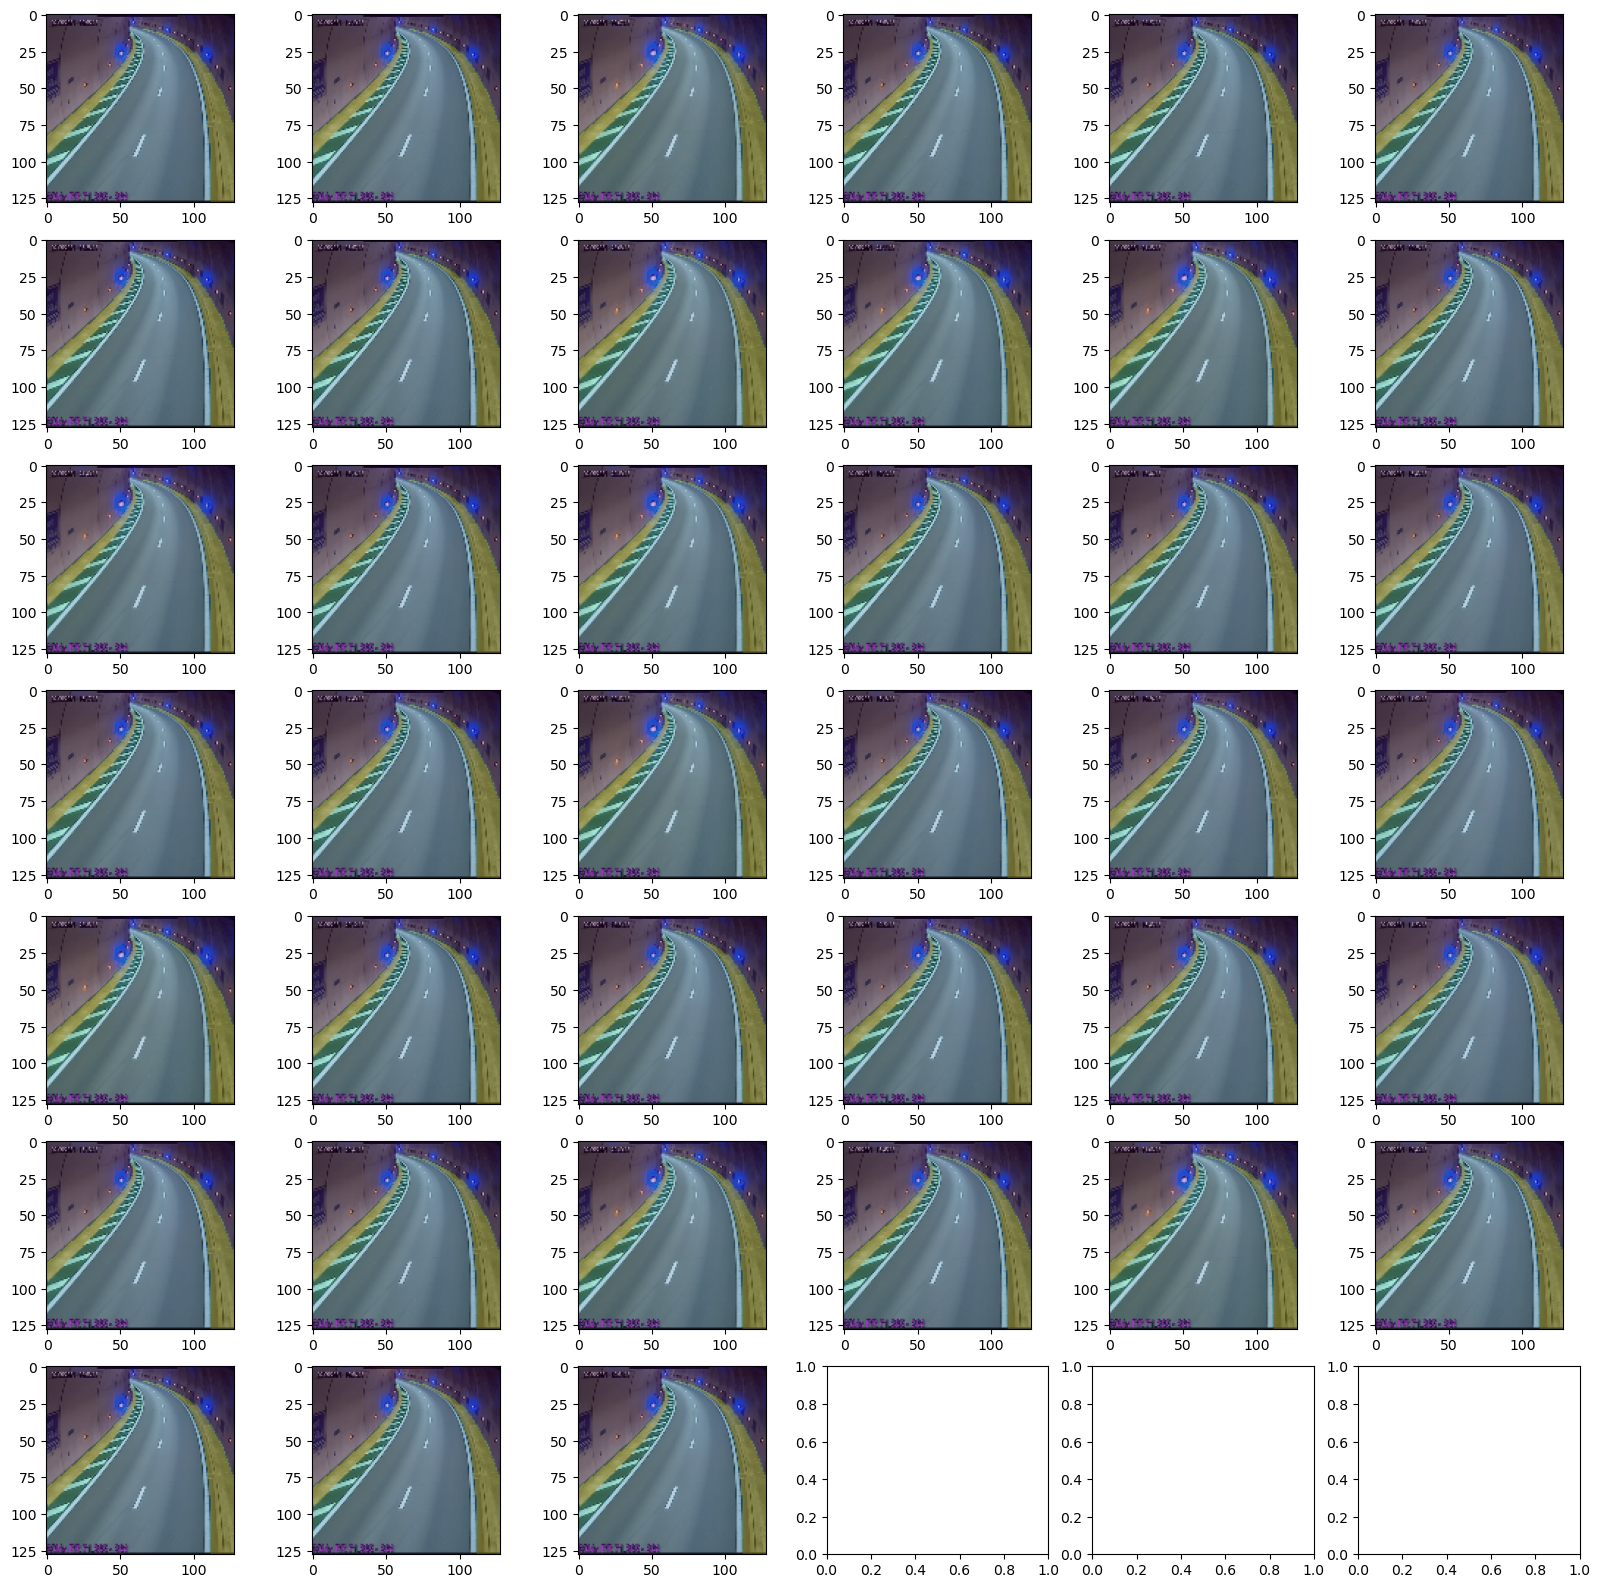

In [17]:
images, masks = [],[]
for image, mask in train_batches[10]:
    images += [image]
    masks += [mask]

fig,axs = show(images, masks, figsize=(20,20))